In [ ]:
!jt -t chesterish

In [ ]:
'''
To change the theme use the following command:
!jt -t <theme-name>

Theme names: 
1) chesterish 
2) onedork  (currently using)
    !jt -t onedork -f roboto -fs 12
3) monokai
 more here: https://github.com/dunovank/jupyter-themes
 
 
 other: https://towardsdatascience.com/bringing-the-best-out-of-jupyter-notebooks-for-data-science-f0871519ca29
'''

Now that we have gathered all the data, its time to clean and prepare them for our clustering algorithm

In [1]:
%run packages_imported.py
%run EDA.py
%run NLP.py
%run Cleaner.py

Load the dataset

In [ ]:
''' FOR SMALLER DF - NEEDS TO GO AT THE BEGINNING
frame1 = df_all_news_processed.loc[df_all_news_processed['Category'] == 'entertainment'][:1200]
frame2 = df_all_news_processed.loc[df_all_news_processed['Category'] == 'financial'][:1600]
frame3 = df_all_news_processed.loc[df_all_news_processed['Category'] == 'political'][:2000]
frame4 = df_all_news_processed.loc[df_all_news_processed['Category'] == 'sport'][:4500]
frame5 = df_all_news_processed.loc[df_all_news_processed['Category'] == 'technology'][:2800]
frame6 = df_all_news_processed.loc[df_all_news_processed['Category'] == 'world'][:1000]
frame7 = df_all_news_processed.loc[df_all_news_processed['Category'] == 'travel'][:3800]

frames = [frame1, frame2, frame3, frame4, frame5, frame6, frame7]
df_processed_smaller = pd.concat(frames)
df_processed_smaller.reset_index()
df_processed_smaller.to_pickle('data/original_data/pickles/df_processed_smaller_before_NLP')'''

In [2]:
#df_all_news = pd.read_excel("data\\original_data\\all_news.xlsx")
#df_all_news.drop(['Unnamed: 0'], axis=1, inplace=True) #drop the unecessary columns

df_all_news = pd.read_pickle(r'data/original_data/pickles/all_news')

#store the number of records. Will be used for generating statistics
initial_size = len(df_all_news)

In [ ]:
df_all_news.head()

## Exploring the dataset

Count the number of records for each category and store it in a secondary dataframe that it will help us produce our visualisations

In [10]:
df_process_stats = EDA.count_records_per_label(df_all_news, "Count_Pre_Processing")

In [ ]:
EDA.display_distribution_donut(df_process_stats, 'Count_Pre_Processing', 'Category')

We can clearly see that the sports class is dominating as it's sometimes x3 or almost x4 times bigger that the rest. Class political that it comes second, also seems to be double the size of the smaller classes. That is a hint that it tells us that most probably we are going to need to balance our classess before proceed to the modeling.

As always, let's check for null values

In [ ]:
#df_all_news = Cleaner.drop_null_values(df_all_news)

In [ ]:
#df_all_news = Cleaner.drop_null_values(df_all_news)
df_all_news.isnull().any()

#### OK, so there no null values, but what about duplicated records? Since we are talking about news articles with hundrends of words per article, we assume that there are no identical articles. 

In [ ]:
pd.options.display.max_colwidth = 1000

In [ ]:
df_all_news.Text.duplicated().any()

It appears that there are duplicated records. But that's weird for text articles, isn't it? Curious how they look like? Let's give a look

In [ ]:
temporary = df_all_news.loc[df_all_news.Text.duplicated()]
temporary.sort_values(by='Text', ascending=False, inplace=True)
temporary

According to duplicated retrieval function there are more than 100k duplicated records (!), that is 1/5 of our initial dataset. <br/>However we see from the head() of the dataset that are a lot of non-ascii characters in the beginning of the articles and even though they have different content, they are recognised as incorrectly as duplicates. <br/>One other interesting thing that we observed is that in the end of the dataframe, '\n' is considered to be the smallest 'word'. That explains why we didn't find any null values in the dataframe.<br/><br/>In order to take a deeper look into this, we will count the number of words of each article but first let's free some memory ;) 

In [ ]:
del [temporary]
gc.collect()

#### Count the number of words of each article - Time comparisons between two options

In [ ]:
t1 = time.time() 
df_all_news['Text_TotalWords'] = EDA.count_words_per_records_opt_1(df_all_news)
EDA.process_time(round(time.time()-t1))

In [3]:
t1 = time.time() 
#df.col.apply(lambda x: len(x.split()))
df_all_news['Text_TotalWords'] = EDA.count_words_per_records_opt_2(df_all_news)
EDA.process_time(round(time.time()-t1))

Process completed.
Time taken: 16 seconds


TODO: comment about the two comparisons

In [7]:
df_all_news.reset_index(drop=True, inplace=True)
df_all_news_processed = df_all_news.copy()

#replaces the '\n' with single space
df_all_news_processed = Cleaner.remove_new_line(df_all_news_processed)

#explain why we remove 10 and less. perhaps an article to answer this?
df_all_news_processed = df_all_news_processed[df_all_news_processed['Text_TotalWords'] > 10]  
print("Removed {} records with less than 10 words".format((len(df_all_news)-len(df_all_news_processed))))

#df_all_news_processed.to_pickle('data/original_data/pickles/df_all_news_processed_v1')

Removed 16195 records with less than 10 words


In [11]:
df_process_stats['Count_Post_Processing'] = EDA.count_records_per_label(df_all_news_processed, "Count_Post_Processing")['Count_Post_Processing']
df_process_stats

,Category,Count_Pre_Processing,Count_Post_Processing
0,entertainment,50282,47279
1,financial,47851,47271
2,political,87157,85315
3,sport,156899,154349
4,technology,41476,39804
5,travel,49470,43832
6,world,60297,59387


In [14]:
#calculate the difference in percentages. Note: the above cell is mandatory for this execution
df_process_stats = EDA.calculate_loss_percentages(df_process_stats, len(df_all_news_processed), initial_size)
df_process_stats

Total records pre-processing: 493432
Total subtracted records: -16195
Total records post-processing: 477237
Total loss: -3.28% of the initial records


,Category,Count_Pre_Processing,Count_Post_Processing,Records_Loss
0,entertainment,50282,47279,-5.97%
1,financial,47851,47271,-1.21%
2,political,87157,85315,-2.11%
3,sport,156899,154349,-1.63%
4,technology,41476,39804,-4.03%
5,travel,49470,43832,-11.4%
6,world,60297,59387,-1.51%


In [ ]:
EDA.display_stats_distribution_pre_post_processing(df_process_stats,'Removing articles with less than 10 words (hover for percentages)')

As we see, there were not significant changes between the categories until now. However, we see that the classes are quite unbalanced between them. We will keep this in mind for now and will review it after the processing.<br/>
*Tip: Click on Pre-Processing to get a view on the current balance of the dataset only*

In [ ]:
#delete future unused variables at this point
del df_all_news, index, row, temp, lossPercentage, df_process_stats, total_loss
gc.collect()

In [ ]:
#df_all_news_processed = pd.read_pickle(r'data/original_data/pickles/df_all_news_processed_v1')
#df_all_news_processed

### Discovering outliers

In [ ]:
EDA.display_outliers_boxplot(df_all_news_processed, "Text_TotalWords", "Text_TotalWords", None, "Visualise the article outliers with extreme number of words (zoom in)")

Using a boxplot to visualise outliers help us understand better the normal distribution of the dataset. However here, due to extreme outliers need to zoom in in order to view the quantiles of the boxplot. After zooming in, we see that the q4 quantile is laying between 1200-1300 total words, for simplicity reasons let's hypothesize 1400 for now. Extreme outliers such as above 1500 number of wrods, are not helping our models therefore we will remove them.

In [ ]:
#display the farest outlier and see what's in it
#df_all_news_processed[df_all_news_processed['Text_TotalWords'] > 50000]

In [ ]:
print("Outliers are equal to {}% of the initial dataset".format((round(((df_all_news_processed[df_all_news_processed['Text_TotalWords'] > 1400].count()[0])/initial_size)*100, 2))))

In [ ]:
#keep records with less than 1500 words
df_all_news_processed = df_all_news_processed[df_all_news_processed['Text_TotalWords'] <= 1400]

In [ ]:
EDA.display_outliers_boxplot(df_all_news_processed, "Text_TotalWords", "Text_TotalWords", None, "Records with less of 1400 words")

The distribution now seems much better. However we left a small padding in the end of the q4 because of the extra processing that we still have to do. Let's see if that will change before feeding the articles to the models

In [ ]:
#checkpoint: save the dataset as pickle pre-processing
df_all_news_processed.to_pickle('data/original_data/pickles/df_all_news_processed_pre_cleaning')

### Start of the main Text-Processing 

In [ ]:
t1 = time.time() 
#df_all_news_processed = Cleaner.drop_duplicate_values(df_all_news_processed)
#df_all_news_processed = Cleaner.remove_new_line(df_all_news_processed)
df_all_news_processed = Cleaner.remove_non_ascii_chars(df_all_news_processed)
df_all_news_processed = Cleaner.remove_multiple_spaces(df_all_news_processed)
#df_all_news_processed = Cleaner.drop_null_values(df_all_news_processed)
#df_all_news_processed = Cleaner.drop_duplicate_values(df_all_news_processed)
EDA.process_time(round(time.time()-t1))

--------------------------------
---- where did you find these noisy words? - Explain on another notebook

In [ ]:
########## N-GRAMS ###########
'''articles_split_by_word = NLP.tokenization(df_all_news_processed)
n = 3 #Specify for N-Grams
occurrences = EDA.find_most_common_n_grams(articles_split_by_word, n)'''

In [ ]:
#sorted(occurrences.items(), key=lambda x: x[1], reverse=True)[:10]

--------------------------------

Remove most noisy words according to N-Grams notebook analysis (link here)

In [ ]:
t1 = time.time()
df_all_news_processed = Cleaner.remove_most_noisy_words(df_all_news_processed)
df_all_news_processed = Cleaner.remove_multiple_spaces(df_all_news_processed)
EDA.process_time(round(time.time()-t1))

'''
#PROBABLY THE FOLLOWING WILL BE REPLACED FROM THE ABOVE
t1 = time.time() 
df_all_news_processed['Text'] = NLP.to_lower_case(df_all_news_processed, 'Text')
df_all_news_processed = Cleaner.remove_most_noisy_words(df_all_news_processed, 'noisy_words.txt')
df_all_news_processed = Cleaner.remove_multiple_spaces(df_all_news_processed)
EDA.process_time(round(time.time()-t1))'''


In [ ]:
t1 = time.time() 
df_all_news_processed['Text'] = NLP.to_lower_case(df_all_news_processed, 'Text')
articles_split_by_word = NLP.tokenization(df_all_news_processed)
df_all_news_processed['Text'] = articles_split_by_word.apply(NLP.remove_stop_words)
df_all_news_processed['Text'] = df_all_news_processed['Text'].apply(NLP.rejoin_words) 
#df_all_news_processed = Cleaner.remove_punctuation(df_all_news_processed)
df_all_news_processed = Cleaner.remove_single_chars(df_all_news_processed)
df_all_news_processed = Cleaner.remove_double_chars(df_all_news_processed)
df_all_news_processed = Cleaner.remove_punctuation_v2(df_all_news_processed)
df_all_news_processed = Cleaner.remove_multiple_spaces(df_all_news_processed)

EDA.process_time(round(time.time()-t1))

In [ ]:
t1 = time.time()

df_all_news_processed = Cleaner.remove_links(df_all_news_processed)
df_all_news_processed = Cleaner.remove_dates(df_all_news_processed)
df_all_news_processed = Cleaner.remove_years(df_all_news_processed)
df_all_news_processed = Cleaner.remove_months(df_all_news_processed)
df_all_news_processed = Cleaner.remove_days(df_all_news_processed)
df_all_news_processed = Cleaner.remove_time(df_all_news_processed)
df_all_news_processed = Cleaner.remove_punctuation(df_all_news_processed)
#second and last iteration of the following 2 cleans
df_all_news_processed = Cleaner.remove_single_chars(df_all_news_processed)
df_all_news_processed = Cleaner.remove_punctuation_v2(df_all_news_processed)
df_all_news_processed = Cleaner.remove_multiple_spaces(df_all_news_processed)
df_all_news_processed = Cleaner.drop_duplicate_values(df_all_news_processed)#maybe this should go on top with null values

EDA.process_time(round(time.time()-t1))

After that we are don with cleaning, it's time to move on to balancing our classes. But before we do so, we must remove unnecessary outliers and proceed with clean and correct records.  

### Outliers removal

In [ ]:
EDA.display_outliers_boxplot(df_all_news_processed, "Text_TotalWords", "Text_TotalWords", None, "Articles with number of words after cleaning")

In [ ]:
#https://help.gooddata.com/doc/en/reporting-and-dashboards/maql-analytical-query-language/maql-expression-reference/aggregation-functions/statistical-functions/predictive-statistical-use-cases/normality-testing-skewness-and-kurtosis
#https://pythontic.com/pandas/dataframe-computations/skew
pre_outliers_size = len(df_all_news_processed)
print("----- (Before outliers removal) Skewness value: -----")
EDA.display_outliers_skewness_value(df_all_news_processed, 'Text_TotalWords')

df_all_news_processed=EDA.remove_outliers_by_iqr_score(df_all_news_processed)

#display_outliers_boxplot(df_all_news_processed, 'Text_TotalWords')
print("\n----- (After outliers removal) Skewness value: -----")
EDA.display_outliers_skewness_value(df_all_news_processed, 'Text_TotalWords')

print("Number of removed outliers: " + str(pre_outliers_size-len(df_all_news_processed)))
total_loss=round((((len(df_all_news_processed)-pre_outliers_size)/pre_outliers_size)*100), 2)
print("\n\n----- Total loss: " + str(total_loss) +"% of the initial records -----")

In [ ]:
EDA.display_outliers_boxplot(df_all_news_processed, "Text_TotalWords", "Text_TotalWords", None, "Our remaining dataset after outliers removal")

In [ ]:
#checkpoint:
#df_all_news_processed.to_pickle('data/original_data/pickles/df_all_news_processed_pre_dataset_distribution')
df_all_news_processed = pd.read_pickle(r'data/original_data/pickles/df_all_news_processed_pre_dataset_distribution')
pd.options.display.max_colwidth = 500
df_all_news_processed

Way to go: <br/>
1) outliers removal (done) <br/>
2) Balancing dataset <br/>
3) N-Grams + Buzzwords (maybe also per category) <br/>
4) NLP (stemming/lemmatize) <br/>
5) Data Normalization <br/>

### Balancing our dataset distribution

First let's see how our current dataset distribution looks like after our cleaning

In [18]:
df_all_news_processed['Text_TotalWords'] = EDA.count_words_per_records_opt_2(df_all_news_processed)

df_process_stats['Count_Post_Processing'] = EDA.count_records_per_label(df_all_news_processed, "Count_Post_Processing")['Count_Post_Processing']

df_process_stats = EDA.calculate_loss_percentages(df_process_stats, len(df_all_news_processed), initial_size)
df_process_stats

Total records pre-processing: 493432
Total subtracted records: -126803
Total records post-processing: 366629
Total loss: -25.7% of the initial records


,Category,Count_Pre_Processing,Count_Post_Processing,Records_Loss
0,entertainment,50282,32759,-34.85%
1,financial,47851,41574,-13.12%
2,political,87157,36394,-58.24%
3,sport,156899,128715,-17.96%
4,technology,41476,35306,-14.88%
5,travel,49470,38183,-22.82%
6,world,60297,53698,-10.94%


In [25]:
EDA.display_stats_distribution_pre_post_processing(df_process_stats, "Dataset distribution status post cleaning process")

#### comments for balancing

In [28]:
df_all_news_processed = EDA.balance_dataset_distribution(df_all_news_processed, 0.10, 0.90)

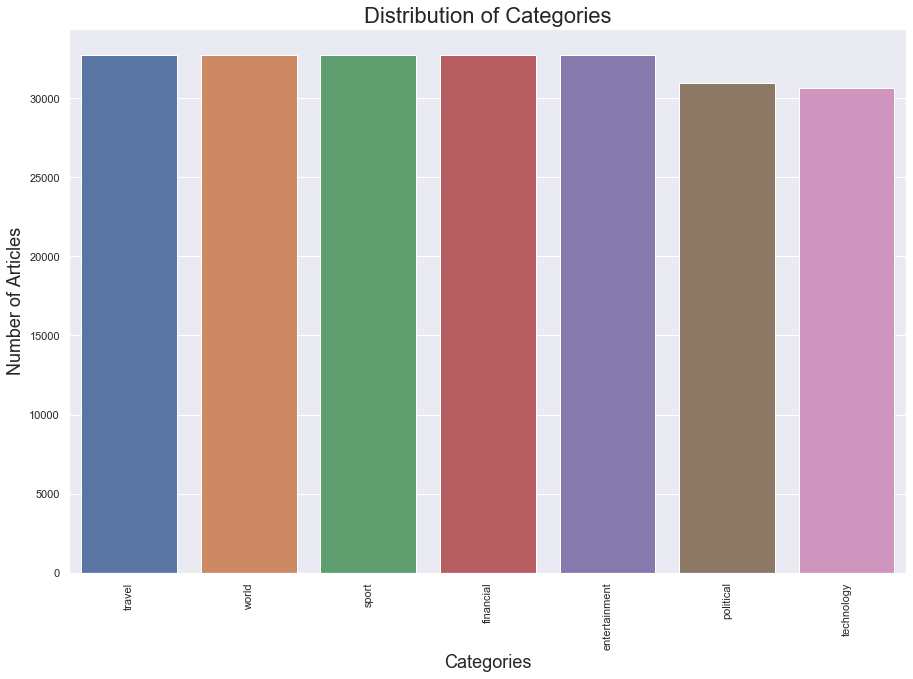

In [30]:
categories_count = test['Category'].value_counts()
EDA.display_distribution_matplot(categories_count
                        ,"Distribution of Categories"
                        ,"Categories"
                        ,"Number of Articles")

In [76]:
df_distribution = EDA.count_records_per_label(test, "Num_Records")
EDA.display_distribution_donut(df_distribution, 'Num_Records', 'Category', 'Dataset distribution after balancing with undersampling method (hover)')

## NLP & N-Grams / Buzzwords

In [ ]:
# Lemma works. Perhaps use another lemma? https://www.machinelearningplus.com/nlp/lemmatization-examples-python/#wordnetlemmatizer
t1 = time.time() 
articles_split_by_word = NLP.tokenization(df_all_news_processed)
df_all_news_processed['Text'] = NLP.stemming(articles_split_by_word)
df_all_news_processed['Text'] = df_all_news_processed['Text'].apply(NLP.rejoin_words) 

EDA.process_time(round(time.time()-t1))
#took approx 24 mins on my pc 

In [ ]:
##### NAME ENTITY RECOGNITION - START #####   
###########################################
'''
MY COMMENTS:
Entity Recognition package of NLTK does not work fully efficiently. It recognises false names.
More importantly is super slow for 10 articles and it would require way better hardware capabilities to run for
my large corpus 300k+ articles.

todo: In the end I will exclude the jar files from the libraries folder and I will just mention 
it as observation to my final report.
'''
from nltk.tag import StanfordPOSTagger
import nltk 
nltk.download('punkt')

import os

java_path = "C:/Program Files/Java/jdk1.8.0_201/bin/java.exe"   
os.environ['JAVAHOME'] = java_path


# Add the jar and model via their path (instead of setting environment variables):
jar = 'libraries/stanford-postagger-full-2020-08-06/stanford-postagger.jar'
model = 'libraries/stanford-postagger-full-2020-08-06/models/english-left3words-distsim.tagger'
pos_tagger = StanfordPOSTagger(model, jar, encoding='utf8')

def find_names(row):
    for sent in nltk.sent_tokenize(row):
        tokens = nltk.tokenize.word_tokenize(sent)
        tags = pos_tagger.tag(tokens)
        print(tags)
        for tag in tags:
            if tag[1] in ["NNP"]:
                print(tag)
        print("-----")
######################################            

df_test=df_all_news_processed[:5].copy()
df_test['Text'] = df_test['Text'].str.upper()
df_test['Text'].apply(find_names) 

##### NAME ENTITY RECOGNITION - END #####     
######################################### 


In [ ]:
EDA.display_buzzwords(list(df_processed_smaller['Text'].values))

In [ ]:
df_all_news_processed['clean_data'] = df_all_news_processed['clean_data'].apply(NLP.rejoin_words) 
df_all_news_processed.head(20)

In [ ]:
#test = df_all_news_processed[:100].copy()
test = df_all_news_processed.copy()
test

In [ ]:
#test.replace(',',' ', regex=True, inplace=True)
#YOU NEED TO PASS THE DATA AS A LIST WITHOUT COMMA WITHIN THE TEXT.
EDA.display_buzzwords(list(df_all_news_processed['Text'].values))
'''
buzzwords bechmark on my MAC: 16 GB 1600 MHz DDR3 / 2,5 GHz Quad-Core Intel Core i7
    / articles: 324.965 
    / total number of words: 150.614.863 (with stopwords)
    / process time: 2.631 seconds (around 44 minutes)
'''

In [ ]:
df_all_news_processed.head(2)

In [ ]:
#df_all_news_processed.groupby(['Category']).mean()
asdf = df_all_news_processed.groupby('Category')['Text_TotalWords'].mean()
EDA.display_distribution(asdf
                        ,"Mean Number of words per Article by Categories"
                        ,"Categories"
                        ,"Mean N# of words")

In [ ]:
categories_count = df_all_news_processed['Category'].value_counts()
EDA.display_distribution(categories_count
                        ,"Distribution of Categories"
                        ,"Categories"
                        ,"Number of Articles")

In [ ]:
df_all_news_processed

In [ ]:
''''''''''''''''''' ___MAIN PIPELINE___ '''''''''''''''''''

df_all_news = pd.read_pickle(r'data/original_data/pickles/all_news')

### Cleaning part
df_all_news['Text_TotalWords'] = EDA.count_words_per_records_opt_2(df_all_news)

df_all_news.reset_index(drop=True, inplace=True)

df_all_news_processed = df_all_news.copy()
#remove outliers - first phase
df_all_news_processed = df_all_news_processed[df_all_news_processed['Text_TotalWords'] > 10] 
df_all_news_processed = df_all_news_processed[df_all_news_processed['Text_TotalWords'] < 3000] 

df_all_news_processed = Cleaner.drop_duplicate_values(df_all_news_processed)
df_all_news_processed = Cleaner.remove_new_line(df_all_news_processed)
df_all_news_processed = Cleaner.remove_non_ascii_chars(df_all_news_processed)
df_all_news_processed = Cleaner.remove_multiple_spaces(df_all_news_processed)
df_all_news_processed = Cleaner.drop_null_values(df_all_news_processed)
df_all_news_processed = Cleaner.drop_duplicate_values(df_all_news_processed)

In [ ]:
df_all_news_processed

In [ ]:
#N-grams function (done)
#buzzwords function (done)
#sentence encoder (too large texts to visaulise interactively)


df_all_news_processed['Text'] = NLP.to_lower_case(df_all_news_processed, 'Text')
df_all_news_processed = Cleaner.remove_most_noisy_words(df_all_news_processed, 'noisy_words.txt')
df_all_news_processed = Cleaner.remove_multiple_spaces(df_all_news_processed)

In [ ]:
articles_split_by_word = NLP.tokenization(df_all_news_processed)
df_all_news_processed['Text'] = articles_split_by_word.apply(NLP.remove_stop_words)
df_all_news_processed['Text'] = df_all_news_processed['Text'].apply(NLP.rejoin_words) 
print("reached here")
df_all_news_processed = Cleaner.remove_punctuation(df_all_news_processed)
df_all_news_processed = Cleaner.remove_single_chars(df_all_news_processed)
df_all_news_processed = Cleaner.remove_multiple_spaces(df_all_news_processed)
#CHECKPOINT: Print N-grams

In [ ]:
df_all_news_processed

In [ ]:
df_all_news_processed = Cleaner.remove_links(df_all_news_processed)
df_all_news_processed = Cleaner.remove_dates(df_all_news_processed)
df_all_news_processed = Cleaner.remove_years(df_all_news_processed)
df_all_news_processed = Cleaner.remove_months(df_all_news_processed)
df_all_news_processed = Cleaner.remove_days(df_all_news_processed)
df_all_news_processed = Cleaner.remove_time(df_all_news_processed)
df_all_news_processed = Cleaner.remove_multiple_spaces(df_all_news_processed)
#CHECKPOINT: Print N-grams

In [ ]:
#lemmatize (if applicable)
#remove outliers
df_all_news['Text_TotalWords'] = EDA.count_words_per_records_opt_2(df_all_news_processed)
df_all_news_processed = df_all_news_processed[df_all_news_processed['Text_TotalWords'] > 10]
df_all_news_processed = df_all_news_processed[df_all_news_processed['Text_TotalWords'] < 600]

#N-grams function (done)
#buzzwords function (done)



In [ ]:
t1 = time.time() 

articles_split_by_word = NLP.tokenization(df_all_news_processed)
df_all_news_processed['Text'] = NLP.stemming(articles_split_by_word)
df_all_news_processed['Text'] = df_all_news_processed['Text'].apply(NLP.rejoin_words) 

t2 = time.time() 
print("Process completed.\nTime taken:") 
print("{:.2f}".format(round(t2-t1, 2))+" seconds.")

#took 1446 seconds(approx 24 mins) on my pc 

In [ ]:
df_all_news_processed

In [ ]:
#df_all_news_processed.to_pickle('data/original_data/pickles/df_all_news_processed_stemmed')

### Data Normalization & Feature Engineering  (normalize, tf-idf vectors)

In [ ]:
t1 = time.time() 

from sklearn.feature_extraction.text import TfidfVectorizer
tfidfconverter = TfidfVectorizer(max_features=1500, min_df=5, max_df=0.7)
X = tfidfconverter.fit_transform(df_all_news_processed['Text']).toarray()

t2 = time.time() 
print("Process completed.\nTime taken:") 
print("{:.2f}".format(round(t2-t1, 2))+" seconds.")

In [ ]:
X

In [ ]:
t1 = time.time() 

y = df_all_news_processed['Category']

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier.fit(X_train, y_train) 

t2 = time.time() 
print("Process completed.\nTime taken:") 
print("{:.2f}".format(round(t2-t1, 2))+" seconds.")

In [ ]:
y_pred = classifier.predict(X_test)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

### Model selection (SVM + kNN + naiveBayes + logistic regression on textual data?)

In [ ]:
pd.options.display.max_colwidth = 500
df_all_news_processed.loc[df_all_news_processed['Category'] == 'travel']

In [ ]:
'''######################## Find N-Grams ########################
from collections import Counter
from itertools import chain

#This function is called from find_most_common_n_grams()
def find_ngrams(input_list, n, n_common_words):
    return list(zip(*[input_list[i:] for i in range(n)]))


########### [Input] ###########
########## df: The DataFrame with the data that would like to process
########## n: The number of N-grams 
########## n_top_ngrams: The number the X most common N-grams
########## Returns: A list with the X most common N-grams and their occurrences 
def find_most_common_n_grams(df, n, n_top_ngrams):
    
    n_grams_title = str(n) +'_grams'
    
    df[n_grams_title] = df['Text'].map(lambda x: find_ngrams(x.split(" "), n, 10))
    
    ngrams = df[n_grams_title].tolist()
    ngrams = list(chain(*ngrams))

    #TODO this: should have x,y,z as the n increases 
    # e.g. [(x.lower(), y.lower(), z.lower()) for x,y,z in ngrams] #--> For 3-grams etc.
    #ngrams = [(x.lower(), y.lower()) for x,y in ngrams]

    ngram_counts = Counter(ngrams)
    return ngram_counts.most_common(n_top_ngrams)

#4 stands for: fourgrams. Change to any n value
#20 stands for: display the top 20 n-grams
testing = find_most_common_n_grams(df_all_news_processed, 4, 20)'''

In [ ]:
'''''''''''''''''''' -----NOT USED------''''''''''''''''''''''''''

#THIS CANNOT BE DONE BECAUSE WE DONT WANT TO REPLACE THE OUTLIERS WITH THE MEAN VALUE
#BECAUSE OF THE HIGH NUMBERS OF THE OUTLIERS, WE WANT TO REMOVE THEM COMPLETELY.
#PLUS THIS IS ABOUT NUMBER OF WORDS PER ARTICLE. WE CANT REPLACE ARTICLES WITH OTHER ARTICLES
#BECUASE THAT WOULD MESS UP OUR DATASET.
def remove_outliers_quantile_percentages(df, column_name, low_percent, high_percent):
    low_value = df[column_name].quantile(low_percent)
    high_value = df[column_name].quantile(high_percent)
    df[column_name] = np.where(df[column_name] <low_value, low_value,df[column_name])
    df[column_name] = np.where(df[column_name] >high_value, high_value,df[column_name])
    return df[column_name]
    
display_outliers_skewness_value(test, 'Text_TotalWords')
test['Text_TotalWords'] = remove_outliers_quantile_percentages(test, 'Text_TotalWords', 0.10, 0.90)
display_outliers_skewness_value(test, 'Text_TotalWords')
'''''''''''''''''''' -----NOT USED------''''''''''''''''''''''''''

In [ ]:
######## SERIAL CLEANING STEPS ######
Remove new line
Remove non-ascii chars
Remove multiple spaces
Remove null values
Remove duplicate values
Remove noisy pre-defined words (by list) / n-grams (to-do)
Remove punctuations
to lower(NLP)
Remove single chars
Remove links
Remove years
Remove months (to do)
Remove days
Remove time
Remove multiple spaces
Remove stopwords(NLP)

Remove outliers(EDA)